In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from  sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt 

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('/Users/victoroliveira/Desktop/vonix-py-statistic/src/vonixstatisc/data/pandas_data/data_fluency_queue_no_auto_dialer.csv')

df_to_dict = pd.DataFrame()
df_to_dict2 = pd.DataFrame()
df_to_dict3 = pd.DataFrame()
df_to_dict4 = pd.DataFrame()



df= df.dropna(axis=0)
df = df.loc[(df['handling_time'] > 10) & (df['handling_time'] <90) ]
df_march = df.loc[df['month'] == 'March']
df_queue = df.loc[df['queue_id'] == 'mgmsales']
df_agent = df.loc[df['agent_id'] == 1592]



In [3]:
df_to_dict['time'] = df['timestamp']
df_to_dict['ht'] = df['handling_time']
dict = df_to_dict.set_index('time').to_dict()['ht']

df_to_dict2['time'] = df_march['timestamp']
df_to_dict2['ht'] = df_march['handling_time']
dict2 = df_to_dict2.set_index('time').to_dict()['ht']

df_to_dict3['time'] = df_queue['timestamp']
df_to_dict3['ht'] = df_queue['handling_time']
dict3 = df_to_dict3.set_index('time').to_dict()['ht']

df_to_dict4['time'] = df_agent['timestamp']
df_to_dict4['ht'] = df_agent['handling_time']
dict4 = df_to_dict4.set_index('time').to_dict()['ht']



In [4]:
from datetime import datetime
from time import gmtime, strftime
import time
def transform_dict(data: dict, period: int) -> dict:
    """method that receives dict from database query
    {start_at(timestamp): talk_secs(seconds), ...} and create
    another dict based on the period (15, 30, 1hr) chosen
    {last_timestamp: [12,24,56,12, 90, 100], last_timestamp - period:[195,235,201,300], ... interval of three minutes for standard model}
    For standard model the data from the last period( 15 min, 30 min, 1h) is used to construct forecast for the next period so the return_dict begins with the last timestamp to the first
    """
    seconds = period * 60
    
    return_dict = {}

    keys_array = list(data.keys())
    beginning = keys_array[0]
    limit= beginning + seconds
    end = keys_array[-1]
    arr = []
    break_v = 1
    indice = 0
    while beginning < end:
        if break_v == beginning:
            break
        break_v = beginning
        for key, value in data.items():
            if key <= limit:
                arr.append(value)
                continue
        
            return_dict[f"{datetime.fromtimestamp(beginning)}"] = arr
            indice += 1
            arr = []
            arr.append(value)
            beginning = key
            limit = beginning + seconds
            

    return return_dict

In [5]:
dict_transformed = transform_dict(dict,15)
mean_object = {i: np.mean(dict_transformed[i]) for i in dict_transformed.keys()}
call_volume = {i: len(dict_transformed[i]) for i in dict_transformed.keys()}
cv_object = {i: np.std(dict_transformed[i]) for i in dict_transformed.keys()}

dict_transformed2 = transform_dict(dict2,15)
mean_object2 = {i: np.mean(dict_transformed2[i]) for i in dict_transformed2.keys()}
call_volume2 = {i: len(dict_transformed2[i]) for i in dict_transformed2.keys()}
cv_object2 = {i: np.std(dict_transformed2[i]) for i in dict_transformed2.keys()}

dict_transformed3 = transform_dict(dict3,15)
mean_object3 = {i: np.mean(dict_transformed3[i]) for i in dict_transformed3.keys()}
call_volume3 = {i: len(dict_transformed3[i]) for i in dict_transformed3.keys()}
cv_object3 = {i: np.std(dict_transformed3[i]) for i in dict_transformed3.keys()}

dict_transformed4 = transform_dict(dict4,15)
mean_object4 = {i: np.mean(dict_transformed4[i]) for i in dict_transformed4.keys()}
call_volume4 = {i: len(dict_transformed4[i]) for i in dict_transformed4.keys()}
cv_object4 = {i: np.std(dict_transformed4[i]) for i in dict_transformed4.keys()}

In [6]:
df_to_ml = pd.DataFrame()
df_to_ml['date'] = mean_object.keys()
#df_to_ml['call_volume'] = call_volume.values()
#df_to_ml['cv'] = cv_object.values()
df_to_ml['mean'] = mean_object.values()
df_to_ml['date'] = pd.to_datetime(df_to_ml['date'], infer_datetime_format=True)
df_to_ml.set_index('date', inplace=True)


df_to_ml2 = pd.DataFrame()
df_to_ml2['date'] = mean_object2.keys()
#df_to_ml2['call_volume'] = call_volume2.values()
#df_to_ml2['cv'] = cv_object2.values()
df_to_ml2['mean'] = mean_object2.values()
df_to_ml2['date'] = pd.to_datetime(df_to_ml2['date'], infer_datetime_format=True)
df_to_ml2.set_index('date', inplace=True)

df_to_ml3 = pd.DataFrame()
df_to_ml3['date'] = mean_object3.keys()
#df_to_ml3['call_volume'] = call_volume3.values()
#df_to_ml3['cv'] = cv_object3.values()
df_to_ml3['mean'] = mean_object3.values()
df_to_ml3['date'] = pd.to_datetime(df_to_ml3['date'], infer_datetime_format=True)
df_to_ml3.set_index('date', inplace=True)

df_to_ml4 = pd.DataFrame()
df_to_ml4['date'] = mean_object4.keys()
#df_to_ml4['call_volume'] = call_volume4.values()
#df_to_ml4['cv'] = cv_object4.values()
df_to_ml4['mean'] = mean_object4.values()
df_to_ml4['date'] = pd.to_datetime(df_to_ml4['date'], infer_datetime_format=True)
df_to_ml4.set_index('date', inplace=True)
df_to_ml.shape


(1985, 1)

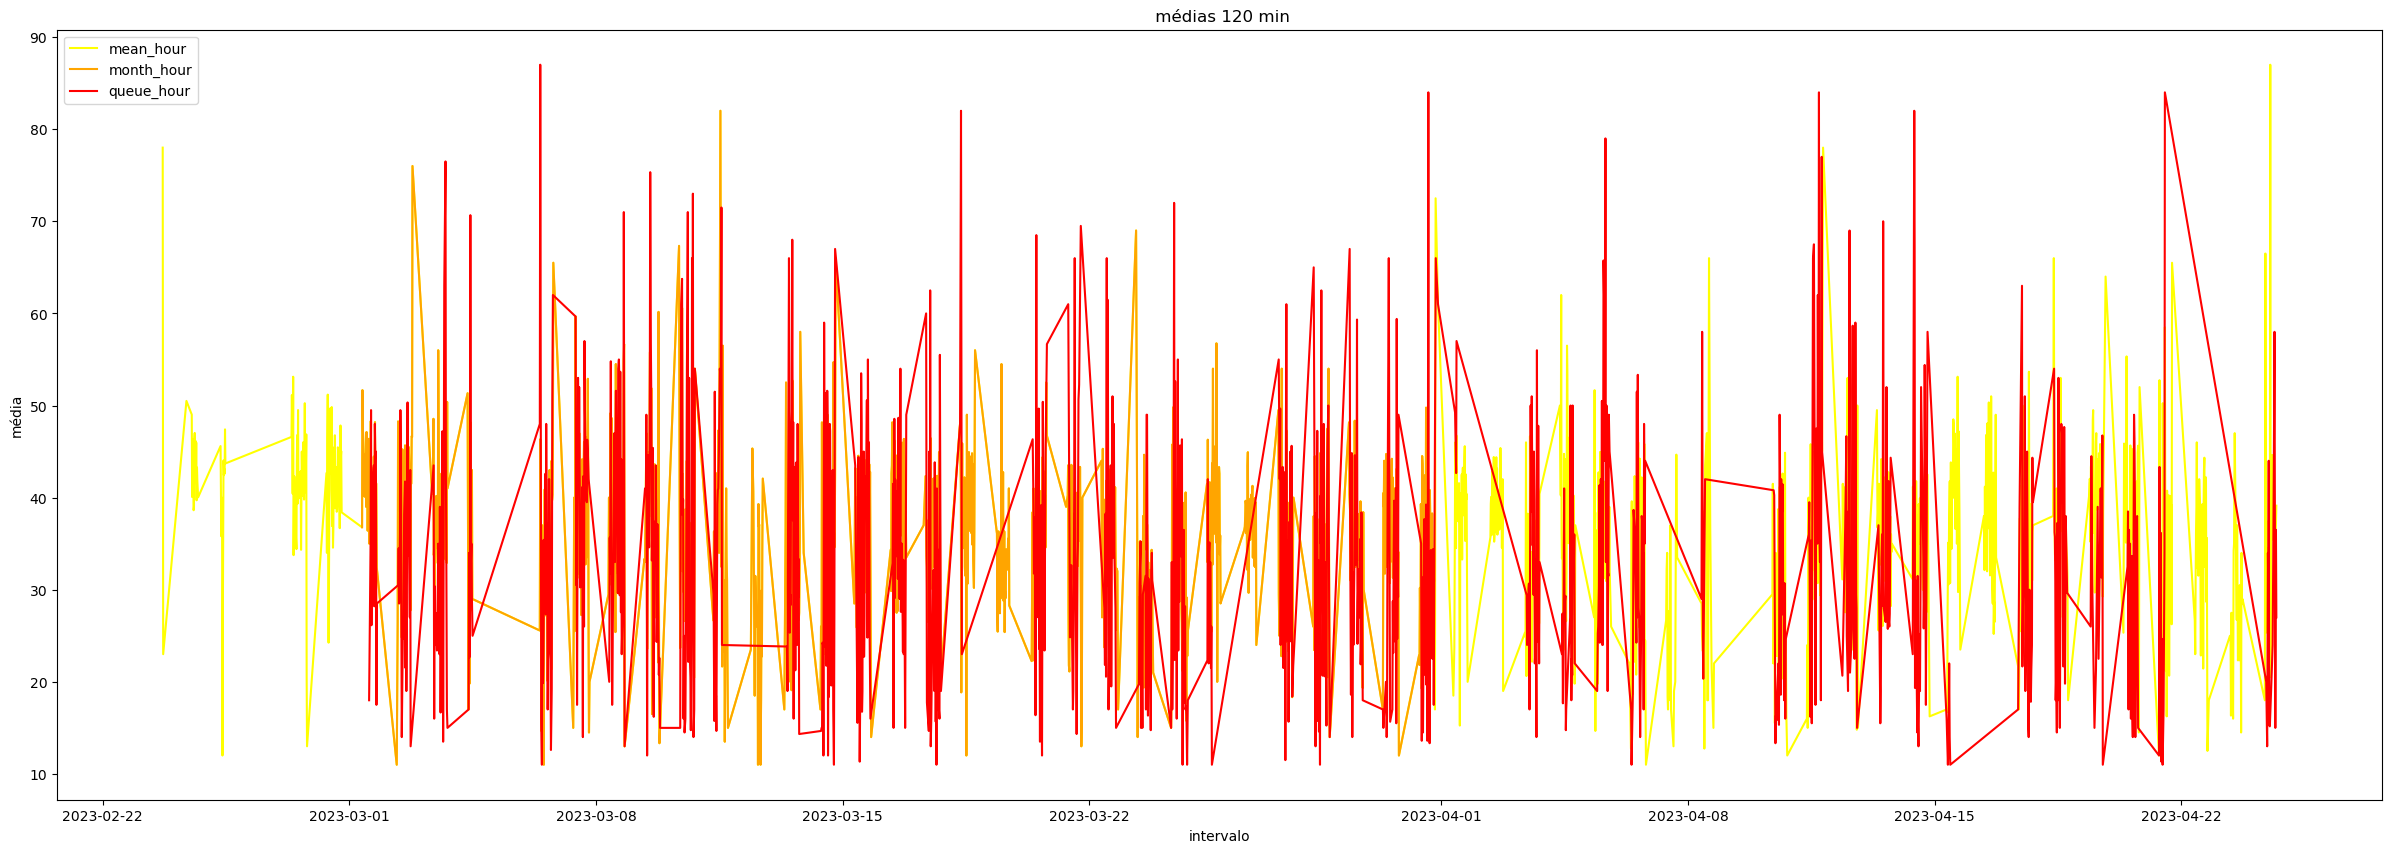

In [7]:
plt.figure(figsize=(30,10))
plt.plot(df_to_ml['mean'], color = 'yellow', label = 'mean_hour')
plt.plot(df_to_ml2['mean'], color = 'orange', label = 'month_hour')
plt.plot(df_to_ml3['mean'], color = 'red', label = 'queue_hour')
#plt.plot(df_to_ml4['mean'], color = 'purple', label = 'agent_hour')
plt.title(' médias 120 min')
plt.xlabel('intervalo')
plt.ylabel('média')
plt.legend()
plt.show()

In [8]:
result = adfuller(df_to_ml['mean'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(result[4])


ADF Statistic: -7.832533411767374
p-value: 6.237616956563592e-12
{'1%': -3.43367377729942, '5%': -2.863008253581611, '10%': -2.5675516375067637}


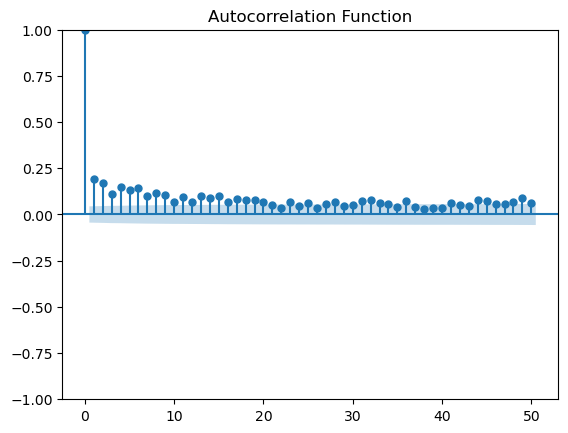

/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


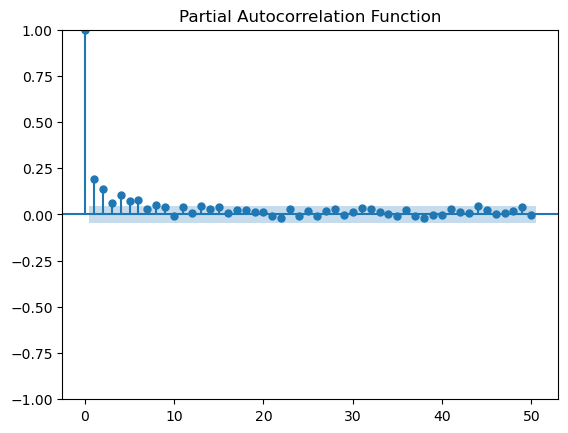

In [9]:
plot_acf(df_to_ml, lags=50)
plt.title("Autocorrelation Function")
plt.show()

plot_pacf(df_to_ml, lags=50)
plt.title("Partial Autocorrelation Function")
plt.show()

In [224]:
train_size = int(len(df_to_ml) * 0.85)
train_data = df_to_ml[:train_size]
test_data = df_to_ml[train_size:]
train_data

,mean
date,
2023-02-23 16:54:36,78.000000
2023-02-23 17:13:44,23.000000
2023-02-24 09:04:11,50.500000
2023-02-24 12:41:54,49.016129
2023-02-24 12:57:03,40.063830
...,...
2023-04-15 14:18:31,39.500000
2023-04-15 14:34:30,45.230769
2023-04-15 14:50:47,39.210526


In [225]:
test_data.index[0]

Timestamp('2023-04-15 15:37:10')

/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


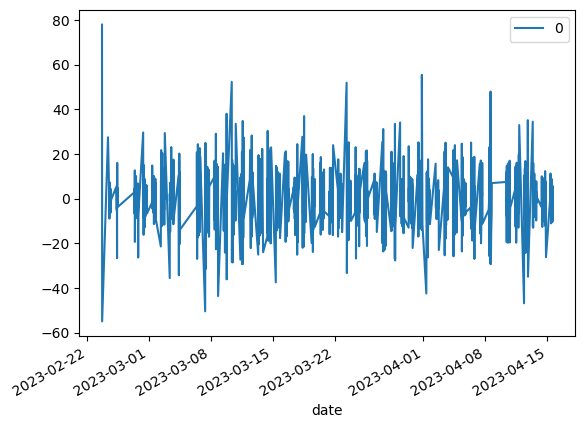

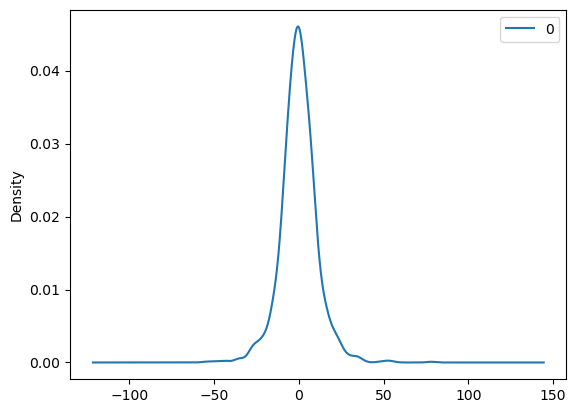

                 0
count  1687.000000
mean      0.021695
std      10.838060
min     -55.000000
25%      -5.712715
50%      -0.208587
75%       5.840858
max      78.000000


In [226]:
model = ARIMA(train_data, order=(0, 1, 0))
model_fit = model.fit()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [236]:
# Make predictions on the test data
predictions = model_fit.predict(start=0, end='2023-04-15', typ='levels' )

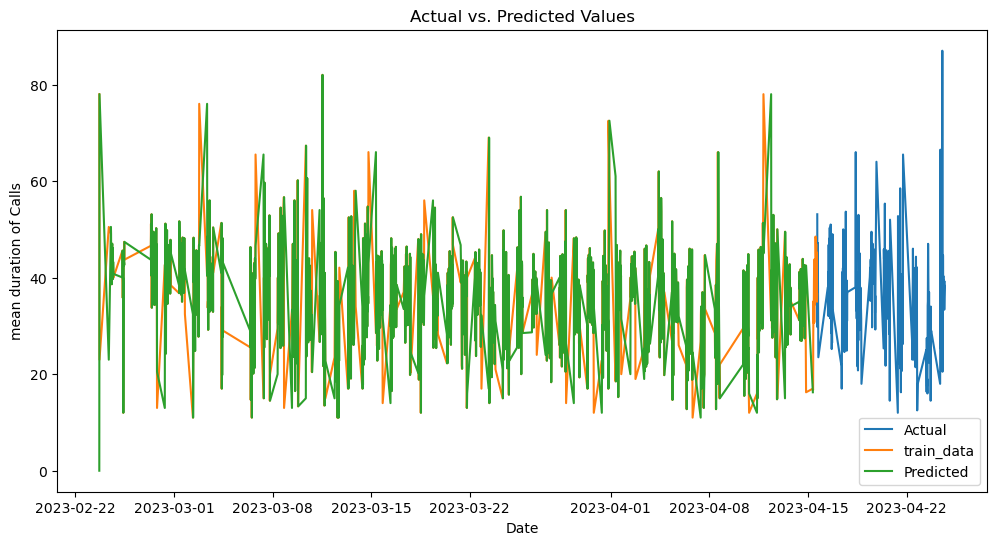

In [237]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(train_data.index, train_data, label='train_data')
#plt.plot(forecast.index, forecast, label='forecast')
plt.plot(predictions.index, predictions, label='Predicted')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Date")
plt.ylabel("mean duration of Calls")
plt.legend()
plt.show()

In [229]:
import statsmodels.api as sm

In [295]:
model_sa=sm.tsa.statespace.SARIMAX(train_data,order=(0, 1, 0),seasonal_order=(1,1,1,12))
results=model_sa.fit()
predictions_sarima = results.predict(start=0, end='2023-04-15', typ='levels' )

/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89222D+00    |proj g|=  1.22725D-01

At iterate    5    f=  3.77888D+00    |proj g|=  1.28757D-02

At iterate   10    f=  3.77556D+00    |proj g|=  1.25514D-03

At iterate   15    f=  3.77538D+00    |proj g|=  2.34438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   9.749D-06   3.775D+00
  F =   3.7753783638613605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


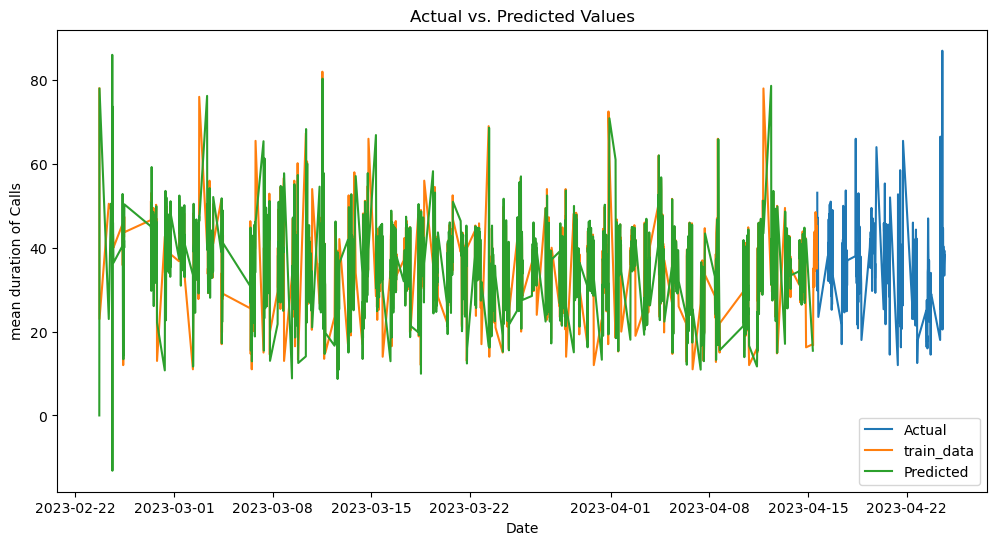

In [296]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(train_data.index, train_data, label='train_data')
#plt.plot(forecast.index, forecast, label='forecast')
plt.plot(predictions_sarima.index, predictions_sarima, label='Predicted')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Date")
plt.ylabel("mean duration of Calls")
plt.legend()
plt.show()

In [297]:
#model_fit.summary()

In [298]:
#results.summary()

In [299]:
from statsmodels.tsa.stattools import acf
from pandas.tseries.offsets import DateOffset

In [314]:
from pandas.tseries.offsets import DateOffset
future_dates=[train_data.index[-1]+ DateOffset(hours=x)for x in range(1,62)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=train_data.columns)
future_df=pd.concat([train_data,future_datest_df])
future_datest_df['mean'] = results.forecast(60, dynamic= True).to_numpy()  
future_datest_df
#results_.to_numpy()
#forecast = results.forecast(1, alpha=0.05)

/opt/homebrew/anaconda3/envs/machine-learning/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,mean
2023-04-15 17:21:42,37.259042
2023-04-15 18:21:42,36.666638
2023-04-15 19:21:42,38.747516
2023-04-15 20:21:42,37.867726
2023-04-15 21:21:42,37.386966
2023-04-15 22:21:42,36.542365
2023-04-15 23:21:42,36.986356
2023-04-16 00:21:42,37.607594
2023-04-16 01:21:42,36.910624
2023-04-16 02:21:42,36.140589
